In this notebook, we are going to implement BERT models to classify between Dementia patients. The models we are going to use are the following:
1. BERT - Baseline
2. Distill-BERT
3. Roberta
4. Albert
5. Electra


In [ ]:
# Access to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import all the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from tabulate import tabulate
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder, label_binarize


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/ADReSS /cleaned_training.csv')
df_test = pd.read_csv('/content/drive/MyDrive/ADReSS /cleaned_testing.csv')
df_train


,Language,Data,Participant,Age,Gender,Diagnosis,Category,mmse,Filename,Transcript,word_count
0,eng,Pitt,PAR,73,0,Control,0,30.0,S024,alright um mother standing kitchen sink water ...,79
1,eng,Pitt,PAR,58,1,ProbableAD,1,20.0,S150,well boy chair stool sr uh falling lady uh wip...,19
2,eng,Pitt,PAR,61,0,Control,0,30.0,S033,mhm well water running floor uh chair stool sr...,27
3,eng,Pitt,PAR,56,0,ProbableAD,1,24.0,S101,f falling uh mother drying dish thing falling ...,31
4,eng,Pitt,PAR,57,0,Control,0,28.0,S032,well little girl saying quiet brother brother ...,44
...,...,...,...,...,...,...,...,...,...,...,...
100,eng,Pitt,PAR,63,0,Control,0,30.0,S016,well girl watching boy go cookie jar cookie ha...,44
101,eng,Pitt,PAR,69,0,Control,0,29.0,S003,okay there little boy he getting he standing h...,60
102,eng,Pitt,PAR,65,0,ProbableAD,1,17.0,S138,water flowing floor shes drying dish he cookie...,11
103,eng,Pitt,PAR,57,1,Control,0,30.0,S038,everything see going okay well little boy stea...,76


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 20 20:24:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             29W /   70W |    1130MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# Set all seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train_model(
    df_train,
    df_test,
    model_name='xlm-roberta-base',
    batch_size=8,
    learning_rate=2e-5,
    num_epochs=5,
    early_stopping_patience=2,
    seed=42
):

    set_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Label encoding
    le = LabelEncoder()
    df_train['label'] = le.fit_transform(df_train['Category'])
    df_test['label'] = le.transform(df_test['Category'])

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df_train['Transcript'].tolist(),
        df_train['label'].tolist(),
        test_size=0.2,
        stratify=df_train['label']
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)

    train_dataset = TextDataset(train_texts, train_labels, tokenizer)
    val_dataset = TextDataset(val_texts, val_labels, tokenizer)
    test_dataset = TextDataset(df_test['Transcript'].tolist(), df_test['label'].tolist(), tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = num_epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_train_preds, all_train_labels = [], []

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_train_loss += loss.item()
            preds = torch.argmax(outputs.logits, axis=1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(batch['labels'].cpu().numpy())
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_loss = total_train_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                total_val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, axis=1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(batch['labels'].cpu().numpy())

        val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

        if epoch == num_epochs - 1 or (patience_counter >= early_stopping_patience):
            print(f"Final Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("\nEarly stopping triggered.")
                break

    model.load_state_dict(best_model_state)

    # Test evaluation
    model.eval()
    all_test_preds, all_test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, axis=1)
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(batch['labels'].cpu().numpy())

    test_acc = accuracy_score(all_test_labels, all_test_preds)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')
    try:
        binarized_labels = label_binarize(all_test_labels, classes=np.arange(len(le.classes_)))
        binarized_preds = label_binarize(all_test_preds, classes=np.arange(len(le.classes_)))
        test_auc = roc_auc_score(binarized_labels, binarized_preds, average='weighted', multi_class='ovr')
    except:
        test_auc = 'N/A (AUC needs probability scores and at least two classes in prediction)'

    print("\nTest Classification Report:")
    print(classification_report(
        all_test_labels,
        all_test_preds,
        target_names=le.inverse_transform(np.unique(all_test_labels)).astype(str),
        zero_division=0
    ))

    # Plot loss and accuracy curves
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    labels = le.inverse_transform(np.unique(all_test_labels))
    ConfusionMatrixDisplay.from_predictions(
        all_test_labels,
        all_test_preds,
        display_labels=labels,
        cmap="Blues",
        xticks_rotation=45
    )
    plt.title(f"Confusion Matrix ({model_name})")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return {
        # "train_loss": train_losses,
        # "val_loss": val_losses,
        # "train_accuracy": train_accuracies,
        # "val_accuracy": val_accuracies,
        "final_train_loss": train_losses[-1],
        "final_val_loss": val_losses[-1],
        "final_train_accuracy": train_accuracies[-1],
        "final_val_accuracy": val_accuracies[-1],
        "val_f1": val_f1,
        "test_accuracy": test_acc,
        "test_f1": test_f1,
        "test_auc": test_auc,
        # "test_preds": all_test_preds,
        # "test_labels": all_test_labels,
        # "label_encoder": le
    }


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final Epoch 6/6
Train Loss: 0.2632 | Val Loss: 0.5121 | Train Acc: 0.9643 | Val Acc: 0.7619 | Val F1: 0.7608

Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        24
           1       0.91      0.83      0.87        24

    accuracy                           0.88        48
   macro avg       0.88      0.88      0.87        48
weighted avg       0.88      0.88      0.87        48



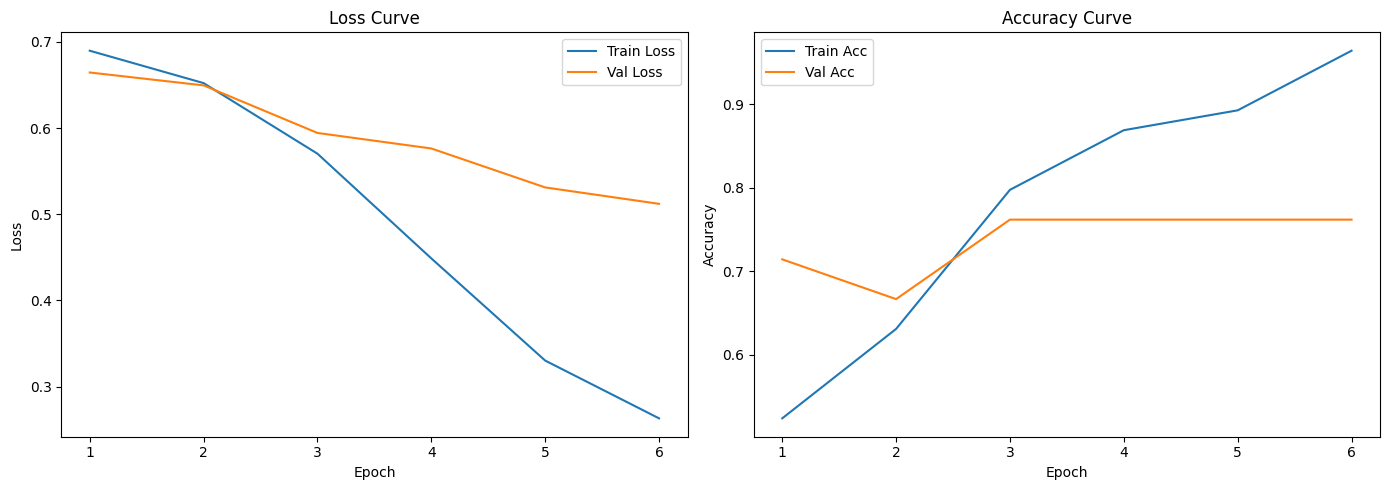

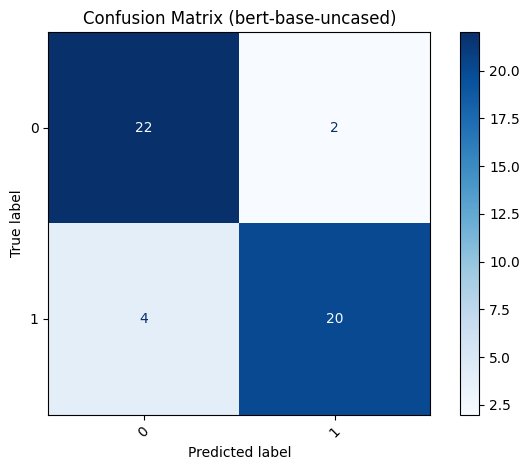

{'final_train_loss': 0.26320672983473,
 'final_val_loss': 0.5121183196703593,
 'final_train_accuracy': 0.9642857142857143,
 'final_val_accuracy': 0.7619047619047619,
 'val_f1': 0.760815081181214,
 'test_accuracy': 0.875,
 'test_f1': 0.8747826086956522,
 'test_auc': np.float64(0.875)}

In [ ]:
# BERT Model
train_model(
    df_train,
    df_test,
    model_name='bert-base-uncased',
    batch_size=8,
    learning_rate=2e-5,
    num_epochs=6,
    early_stopping_patience=3,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final Epoch 6/6
Train Loss: 0.3064 | Val Loss: 0.5903 | Train Acc: 0.9524 | Val Acc: 0.7143 | Val F1: 0.7143

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.82      0.75      0.78        24

    accuracy                           0.79        48
   macro avg       0.79      0.79      0.79        48
weighted avg       0.79      0.79      0.79        48



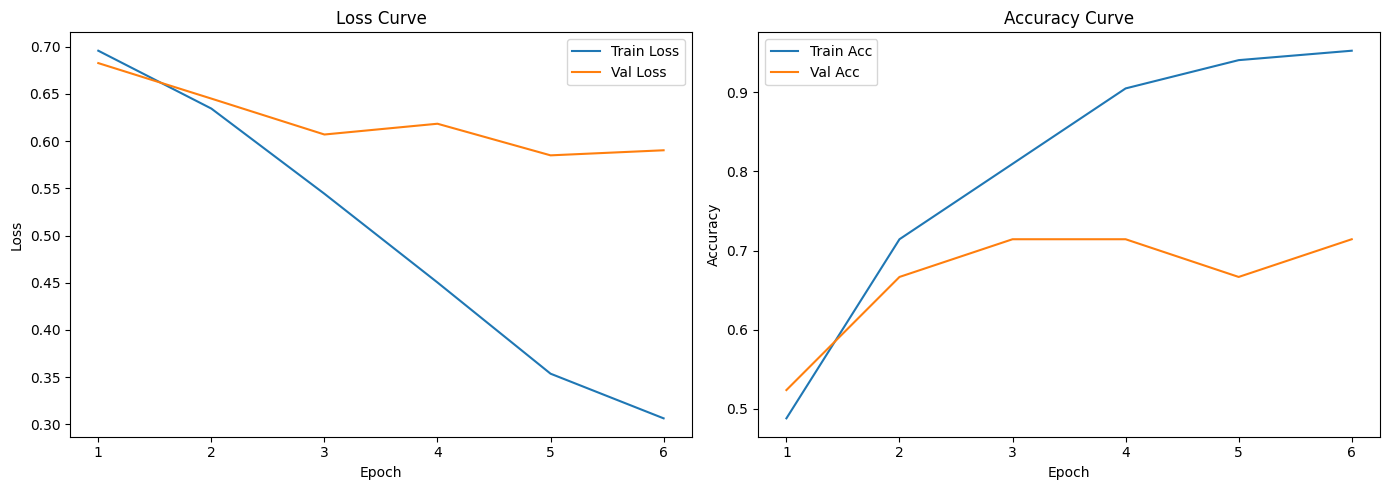

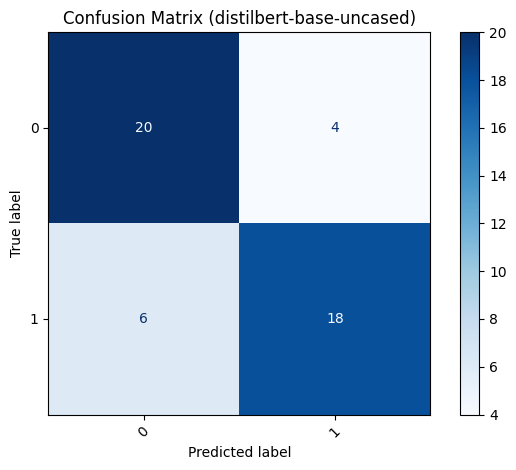

{'final_train_loss': 0.30635024200786243,
 'final_val_loss': 0.5902994076410929,
 'final_train_accuracy': 0.9523809523809523,
 'final_val_accuracy': 0.7142857142857143,
 'val_f1': 0.7142857142857143,
 'test_accuracy': 0.7916666666666666,
 'test_f1': 0.7913043478260869,
 'test_auc': np.float64(0.7916666666666667)}

In [ ]:
# Distill BERT

train_model(
    df_train,
    df_test,
    model_name='distilbert-base-uncased',
    batch_size=8,
    learning_rate=2e-5,
    num_epochs=6,
    early_stopping_patience=3,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final Epoch 5/5
Train Loss: 0.3101 | Val Loss: 0.5828 | Train Acc: 0.8810 | Val Acc: 0.7619 | Val F1: 0.7608

Test Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        24
           1       0.88      0.62      0.73        24

    accuracy                           0.77        48
   macro avg       0.80      0.77      0.77        48
weighted avg       0.80      0.77      0.77        48



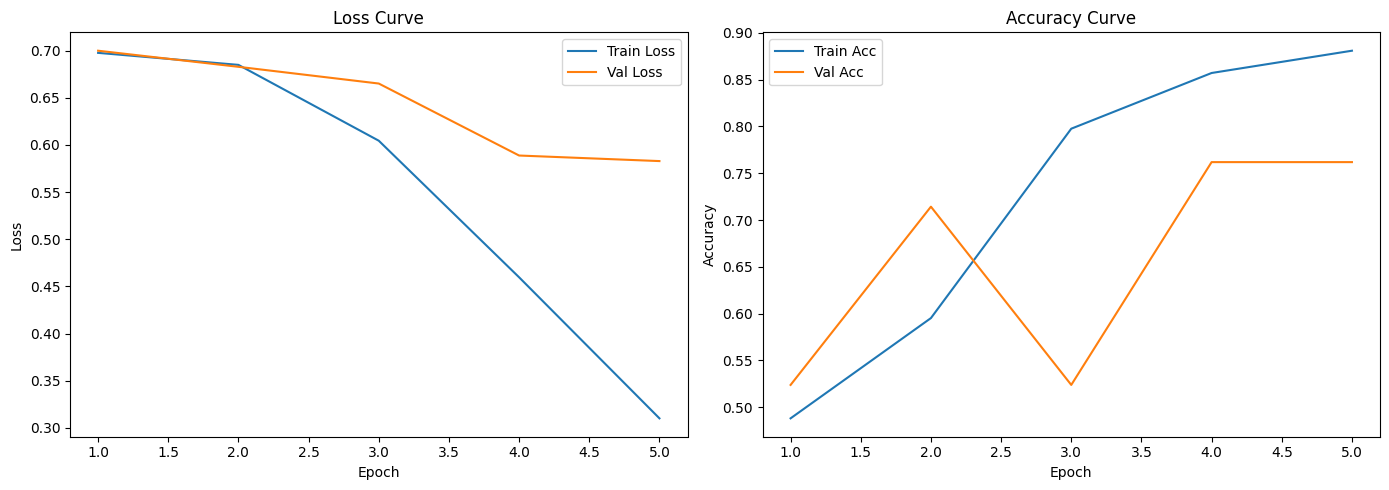

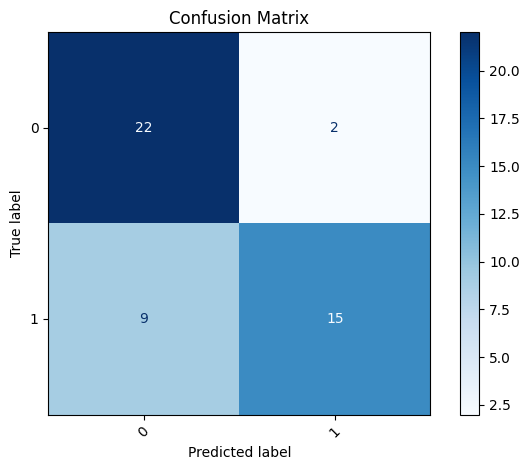

{'final_train_loss': 0.3100637834180485,
 'final_val_loss': 0.5827953120072683,
 'final_train_accuracy': 0.8809523809523809,
 'final_val_accuracy': 0.7619047619047619,
 'val_f1': 0.760815081181214,
 'test_accuracy': 0.7708333333333334,
 'test_f1': 0.7658536585365855,
 'test_auc': np.float64(0.7708333333333333)}

In [ ]:
# Roberta Base Model

train_model(
    df_train,
    df_test,
    model_name='roberta-base',
    batch_size=8,
    learning_rate=2e-5,
    num_epochs=5,
    early_stopping_patience=3,
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final Epoch 5/5
Train Loss: 0.3847 | Val Loss: 0.5644 | Train Acc: 0.8929 | Val Acc: 0.8095 | Val F1: 0.8069

Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.78      0.75      0.77        24

    accuracy                           0.77        48
   macro avg       0.77      0.77      0.77        48
weighted avg       0.77      0.77      0.77        48



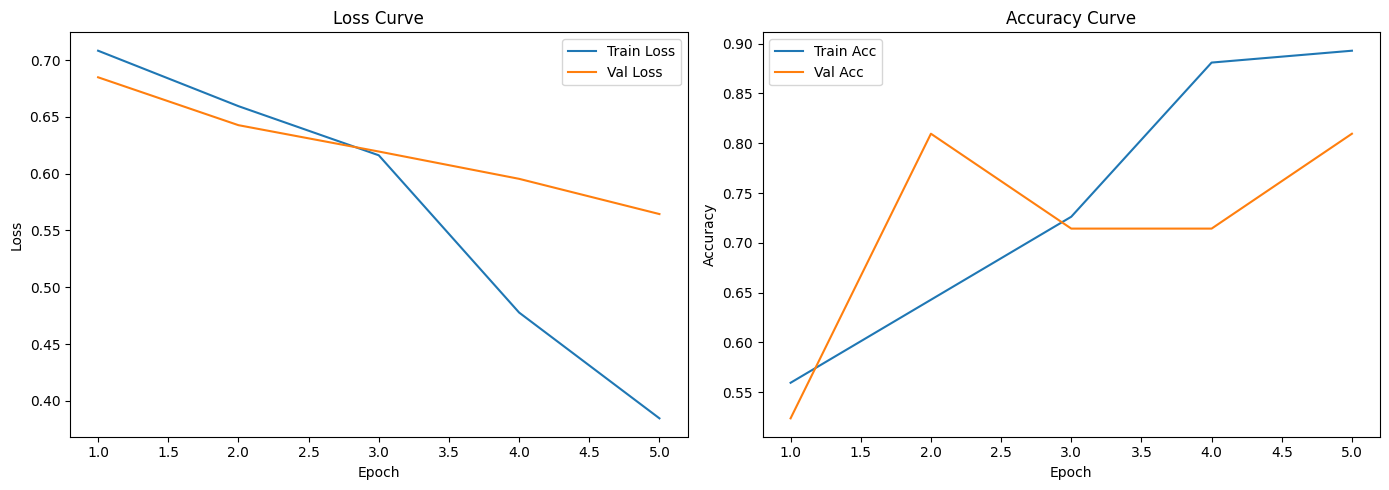

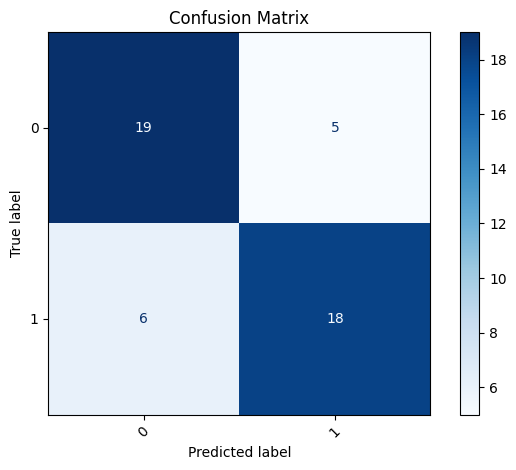

{'final_train_loss': 0.384695367379622,
 'final_val_loss': 0.5644473731517792,
 'final_train_accuracy': 0.8928571428571429,
 'final_val_accuracy': 0.8095238095238095,
 'val_f1': 0.806878306878307,
 'test_accuracy': 0.7708333333333334,
 'test_f1': 0.7707338254450716,
 'test_auc': np.float64(0.7708333333333333)}

In [ ]:
# Albert base model

train_model(
    df_train,
    df_test,
    model_name='albert-base-v2',
    batch_size=8,
    learning_rate=2e-5,
    num_epochs=5,
    early_stopping_patience=3,
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final Epoch 5/5
Train Loss: 0.5397 | Val Loss: 0.6335 | Train Acc: 0.9048 | Val Acc: 0.6667 | Val F1: 0.6420

Test Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.96      0.82        24
           1       0.94      0.62      0.75        24

    accuracy                           0.79        48
   macro avg       0.83      0.79      0.79        48
weighted avg       0.83      0.79      0.79        48



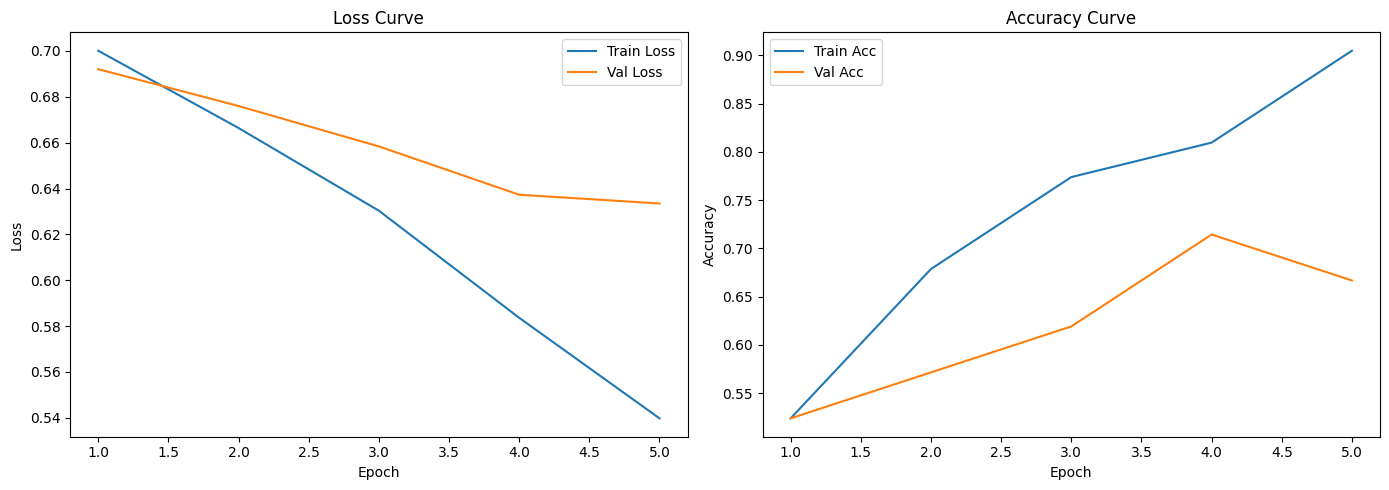

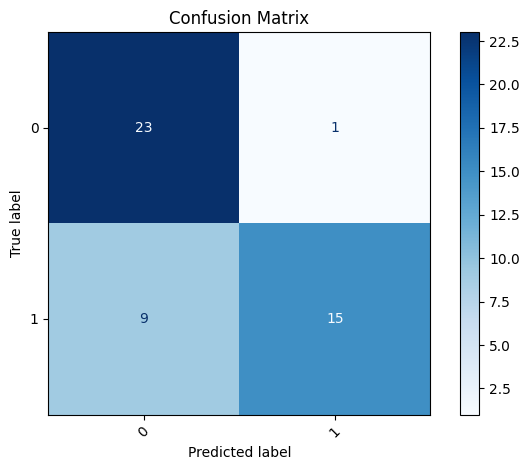

{'final_train_loss': 0.5397099717096849,
 'final_val_loss': 0.6334624091784159,
 'final_train_accuracy': 0.9047619047619048,
 'final_val_accuracy': 0.6666666666666666,
 'val_f1': 0.6419753086419753,
 'test_accuracy': 0.7916666666666666,
 'test_f1': 0.7857142857142857,
 'test_auc': np.float64(0.7916666666666667)}

In [ ]:
# Electra

train_model(
    df_train,
    df_test,
    model_name='google/electra-base-discriminator',
    batch_size=8,
    learning_rate=2e-5,
    num_epochs=5,
    early_stopping_patience=3,
)

In [ ]:
results = {
    "Bert-base":  {"Accuracy": 0.88, "F1": 0.87, "Precision": 0.88, "Recall": 0.88},
    "Distilbert": {"Accuracy": 0.79, "F1": 0.79, "Precision": 0.79, "Recall": 0.79},
    "Roberta":    {"Accuracy": 0.77, "F1": 0.77, "Precision": 0.80, "Recall": 0.77},
    "Albert":     {"Accuracy": 0.77, "F1": 0.77, "Precision": 0.77, "Recall": 0.77},
    "Electra":    {"Accuracy": 0.79, "F1": 0.79, "Precision": 0.83, "Recall": 0.79},
}



def plot_model_comparison(results):
    models = list(results.keys())
    accuracy = [results[m]["Accuracy"] for m in models]
    f1 = [results[m]["F1"] for m in models]
    # precision = [results[m]["Precision"] for m in models]
    # recall = [results[m]["Recall"] for m in models]

    x = np.arange(len(models))
    width = 0.25

    plt.figure(figsize=(12, 4))
    plt.bar(x - width, accuracy, width, label='Accuracy')
    plt.bar(x, f1, width, label='F1 Score')
    # plt.bar(x + width, precision, width, label='Precision')
    # plt.bar(x + 2*width, recall, width, label='Recall')


    plt.xticks(x, models)
    plt.ylabel("Score")
    plt.title("Model Performance Comparison")
    plt.ylim(0, 1)

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.), ncol=3)

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


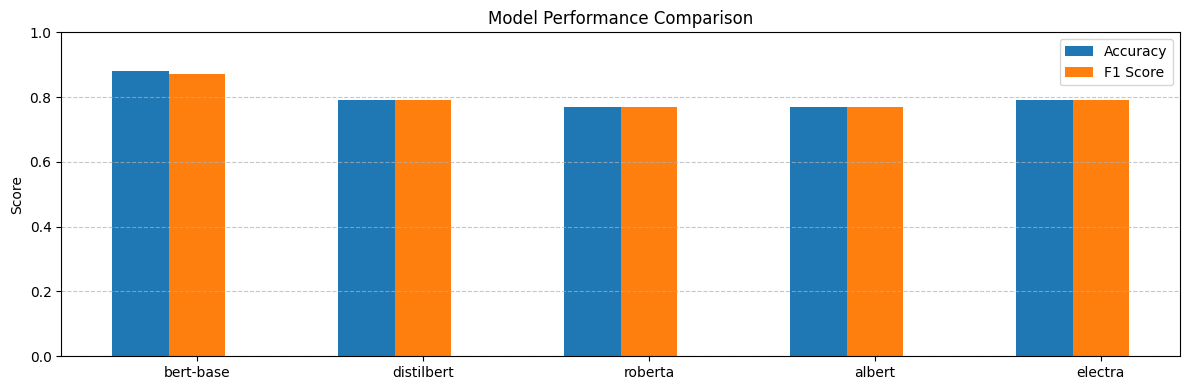

In [ ]:
plot_model_comparison(results)
